In [1]:
from cpymad.madx import Madx

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats
from scipy.optimize import least_squares as ls
from scipy.optimize import minimize as som

from scipy.optimize import fmin_cobyla
from scipy.optimize import shgo

# standard configurations
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display


def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

In [2]:
# constraint for cobyla here
def con1(x):
    return 0.05-np.sum(x**2)


# Home-made truncated gaussian distribution
def trun_norm(cut):
    x = np.random.normal()
    return x+cut if np.abs(x)<cut else trun_norm(cut)
    

# returns a madx string for desired pc = sqrt(E^2-m^2c^4) value
def input_str(x):
    return '''
    
    CALL, FILE = "Optics_v7.str";
    CALL, FILE = "CRYRING_v7.1.0.seq";

    beam, particle = proton, sequence=cryring, pc = {};
    use, sequence=cryring;

    select, flag=twiss, column=apertype, aper_1, aper_2;
    twiss;
    '''.format(x)

#=========================================================================================

# scalar function, it is the characterization of full X-orbit
# The argument is numpy array (list of kickers), len = 8
# returns dx/dk
def find_gradient_x(theta):

#    print(theta)
#    print(np.linalg.norm(theta**2))
    
    kf0=0.5086546699
    kd0 =-0.6511149282
    delta = kf0/100

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
    twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm0 =aux[aux["keyword"]=="hmonitor"]["x"]

    madx.input('''kqfl ={}; kqdl ={};twiss;'''.format(kf0+delta,kd0+delta));

    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]

    vec = np.array(xbpm-xbpm0)/delta

    return np.linalg.norm(vec)



# scalar function, it is the characterization of full Y-orbit
# The argument is numpy array (list of kickers), len = 6
# returns dy/dk
def find_gradient_y(theta):
    
#    print(np.sum(theta**2))
    
    kf0=0.5086546699
    kd0 =-0.6511149282    
    delta = kf0/100

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kv = {};k04kv = {};k07kv = {};k08kv ={};k10kv ={};k12kv ={};
    twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    ybpm0 =aux[aux["keyword"]=="vmonitor"]["y"]

    madx.input('''kqfl ={}; kqdl ={};twiss;'''.format(kf0+delta,kd0+delta));

    aux=madx.table.twiss.dframe()
    ybpm = aux[aux["keyword"]=="vmonitor"]["y"]
    
    vec = np.array(ybpm-ybpm0)/delta

    return np.linalg.norm(vec)

#=========================================================================================



def find_orb_x(theta):
      
    madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282; 
    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};twiss;'''.format(*theta));
       
    aux=madx.table.twiss.dframe()
    xq =aux[aux["keyword"]=="quadrupole"]["x"]
    
    aux =madx.table.efield.dframe()
    Qerr = aux[aux["name"].str.contains("q")]
    
    vec = np.array(np.array(xq)-np.array(Qerr["dx"]))

    
    return np.linalg.norm(vec)


def find_orb_y(theta):
      
    madx.input('''k02kv = {};k04kv = {};k07kv = {};k08kv ={};k10kv ={};k12kv ={};twiss;'''.format(*theta));

    aux=madx.table.twiss.dframe()
    ybpm =aux[aux["keyword"]=="quadrupole"]["y"]
    vec = np.array(np.array(ybpm)-np.array(qsERR["dy"]))

    return np.linalg.norm(vec)


In [3]:
madx = Madx(stdout=False)

pc = np.sqrt(2*0.9382720813*50*10**(-6)) # Kin Energy 50 KeV
myStr0 = input_str(pc)

# check the seed, it can be the cause of the error


dxdy = [trun_norm(2.5) for i in range(2*3*6)]

# str1 and str2 are separated because of .format
# warn PTC doesnt work properly with ealign >=0.005
myStr1 = '''
addquaderr(dx_err,dy_err,quadname): macro = {
SELECT, FLAG=error, clear;
eoption, add=false;
SELECT, FLAG=error, PATTERN="quadname";

EALIGN, DX:=0.001*(dx_err-2.5), DY:=0.001*(dy_err -2.5); 
};'''


# somehow exec doesn't work with negative values
# the sollution is to use the truncated distribution
myStr2 = '''

exec, addquaderr({},{},YR02QS1);
exec, addquaderr({},{},YR02QS2);
exec, addquaderr({},{},YR02QS3);

exec, addquaderr({},{},YR04QS1);
exec, addquaderr({},{},YR04QS2);
exec, addquaderr({},{},YR04QS3);

exec, addquaderr({},{},YR06QS1);
exec, addquaderr({},{},YR06QS2);
exec, addquaderr({},{},YR06QS3);

exec, addquaderr({},{},YR08QS1);
exec, addquaderr({},{},YR08QS2);
exec, addquaderr({},{},YR08QS3);

exec, addquaderr({},{},YR10QS1);
exec, addquaderr({},{},YR10QS2);
exec, addquaderr({},{},YR10QS3);

exec, addquaderr({},{},YR12QS1);
exec, addquaderr({},{},YR12QS2);
exec, addquaderr({},{},YR12QS3);

SELECT, FLAG = ERROR, FULL;
ESAVE, FILE = err.txt;

select,flag=interpolate, class=drift, slice=20, range=#s/#e;
!select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
select,flag=interpolate, class=sbend, slice=10, range=#s/#e;
twiss;
'''.format(*dxdy)

#madx.input('''ksf:=-7.63502808/6;ksd:=7.21301328/6;twiss;''')

madx.input(myStr0);
madx.input(myStr1);
madx.input(myStr2);
DF0=madx.table.twiss.dframe()
bpmDF0 = DF0[DF0["keyword"]=="hmonitor"]
qsPos = DF0[DF0["keyword"]=="quadrupole"]

err =madx.table.efield.dframe()
qsERR = err[err["name"].str.contains("qs")]


In [4]:
theta_x = np.random.normal(0,0.001,8)
theta_y = np.random.normal(0,0.001,6)
#theta_x = np.zeros(8)
#theta_y = np.zeros(6)
cons = [{"type": "ineq", "fun": con1}]

# replace with scipy.optimize.minimize -> in irder to compare number of steps
#vec_xg = fmin_cobyla(find_gradient_x, theta_x, cons=[con1], rhobeg=.001, rhoend=0.0001)
#vec_yg = fmin_cobyla(find_gradient_y, theta_y, cons=[con1], rhobeg=.001, rhoend=0.0001)

vec_xg = som(find_gradient_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .001, 'disp': True})
vec_yg = som(find_gradient_y, theta_y, method="COBYLA", constraints=cons, options={'rhobeg': .001, 'disp': True})

In [5]:
# warn! in order to compare two techniques all parameters should be equal theta_0, rho_beg/end, constraints

#vec_xo = fmin_cobyla(find_orb_x, theta_x, cons=[con1], rhobeg=.001, rhoend=0.0001)
#vec_yo = fmin_cobyla(find_orb_y, theta_y, cons=[con1], rhobeg=.001, rhoend=0.0001)

vec_xo = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .001, 'disp': True})
vec_yo = som(find_orb_y, theta_y, method="COBYLA", constraints=cons, options={'rhobeg': .001, 'disp': True})

In [6]:
# warn! different format of output for fmin_cobyla and som
madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282; 
k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
twiss;'''.format(*vec_xg.x));

madx.input('''k02kv = {};k04kv = {};k07kv = {};k08kv ={};k10kv ={};k12kv ={};twiss;'''.format(*vec_yg.x))

DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]
#------------------------------------------------------------

madx.input('''k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};twiss;'''.format(*vec_xo.x));

madx.input('''k02kv = {};k04kv = {};k07kv = {};k08kv ={};k10kv ={};k12kv ={};twiss;'''.format(*vec_yo.x))

DF1=madx.table.twiss.dframe()
#------------------------------------------------------------


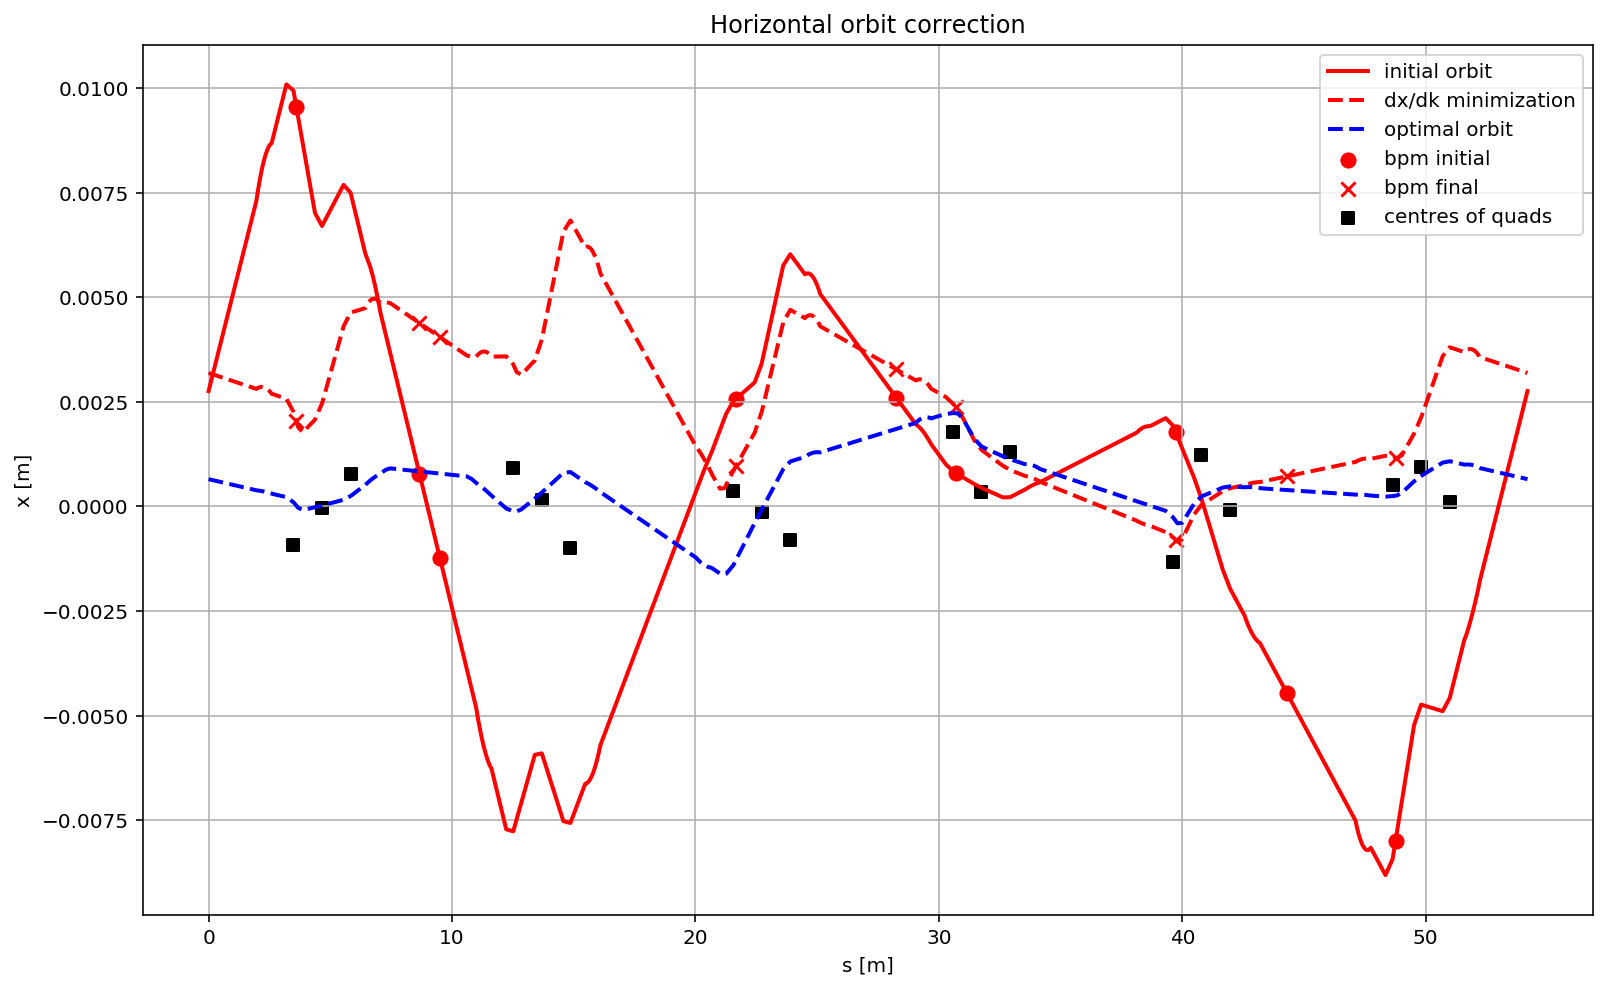

In [7]:
# plotting
# red dashed line stands for find_grad, blue dashed for find_orb

fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.x, color = "red", s = 50, label="bpm initial")

plt.plot(DF['s'],DF['x'],'r',ls="--", label='dx/dk minimization', lw=2)
plt.scatter(bpmDF.s,bpmDF.x, color = "red", s = 50, marker="x", label="bpm final")

plt.plot(DF1['s'],DF1['x'],'blue',ls="--", label='optimal orbit', lw=2)

plt.scatter(qsPos.s,qsERR.dx, label="centres of quads", marker = "s", color = "black")

plt.legend(loc='best')
plt.title("Horizontal orbit correction")
plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()


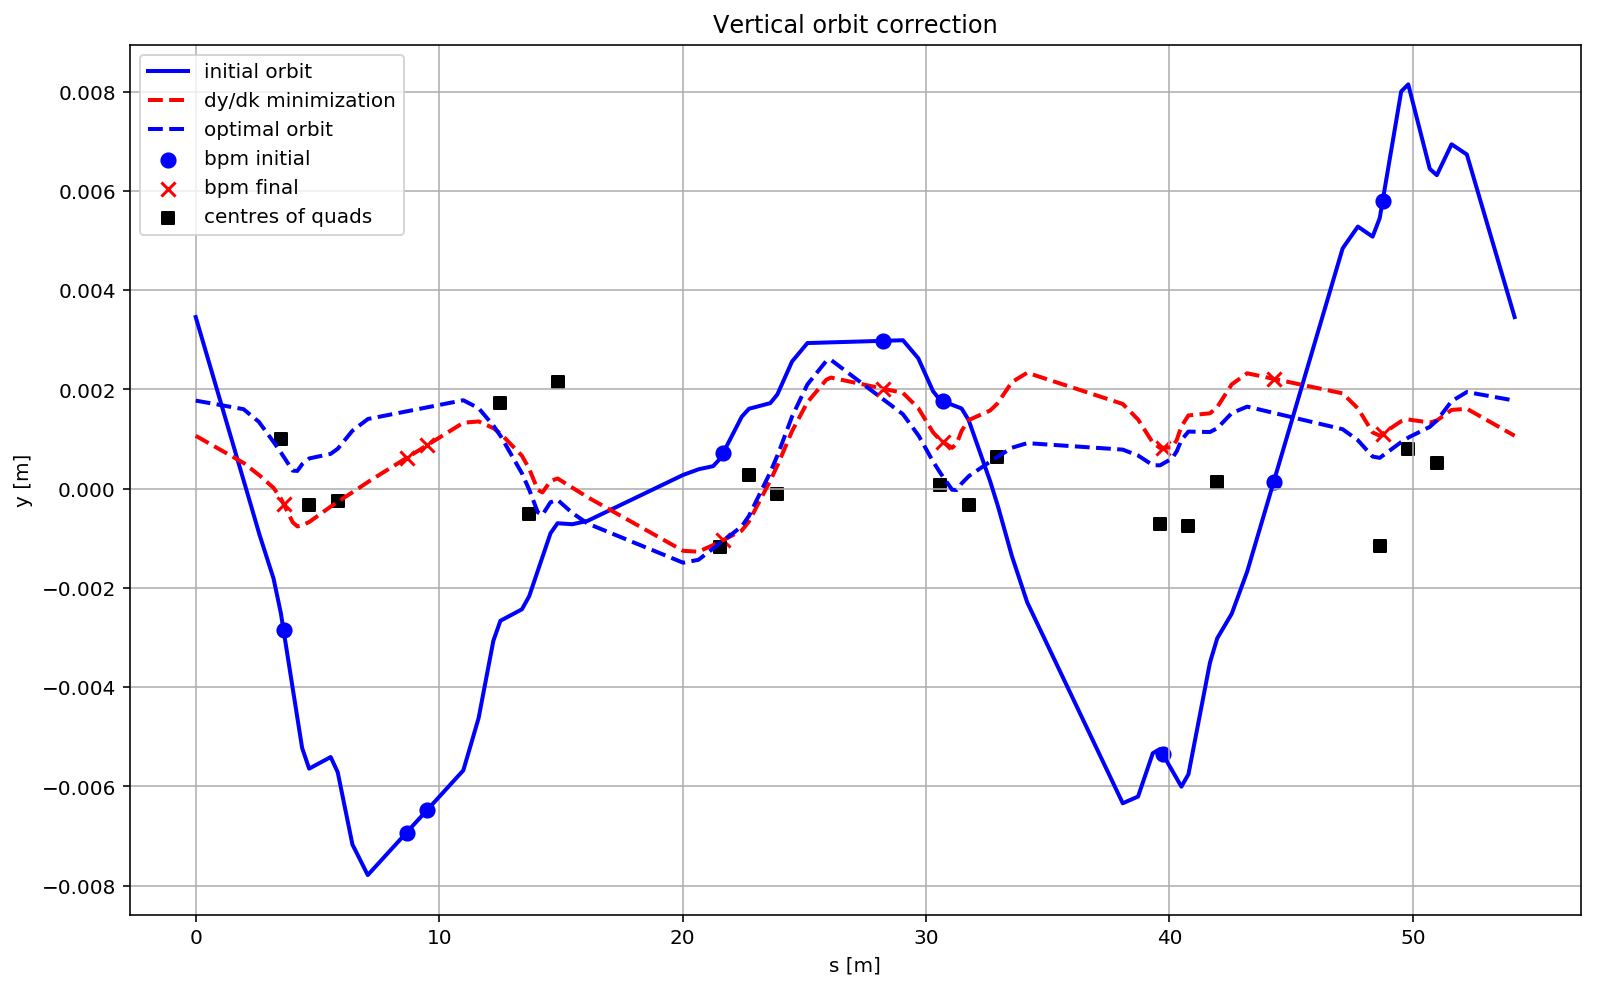

In [8]:
fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['y'],'b', label='initial orbit', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.y, color = "blue", s = 50, label="bpm initial")

plt.plot(DF['s'],DF['y'],'red',ls="--", label='dy/dk minimization', lw=2)
plt.scatter(bpmDF.s,bpmDF.y, color = "red", s = 50, marker="x", label="bpm final")

plt.plot(DF1['s'],DF1['y'],'blue',ls="--", label='optimal orbit', lw=2)

plt.scatter(qsPos.s,qsERR.dy, label="centres of quads", marker = "s", color = "black")

plt.title("Vertical orbit correction")
plt.legend(loc='best')
plt.ylabel('y [m]')
plt.xlabel('s [m]')
plt.grid()

In [9]:
#---- Variation of f-func close to glob min ---

#th = np.linalg.norm(vec_xo.x)/100
#N=20
#aux = []
#tmp1 =[]
#for k in range(8):
#    theta = list(vec_xo.x)[:]
#    theta[k]-=N/2*th
#    aux = []
#    for i in range(N):
#        theta[k]+=th
#        aux.append([theta[k],find_gradient_x(theta)])
#    tmp1.append(np.transpose(aux))

# ---plotting--- put axis!
#fig = plt.figure(figsize=(13,8))
#[plt.plot(tmp1[i][0],tmp1[i][1]) for i in range(8)]
#[plt.axvline(x, ls ="--") for x in vec_xo.x]
#plt.axhline(find_gradient_x(vec_xo.x), ls="--")
#plt.title("The beam passes through the centers of quads")
#plt.grid(True)
#plt.show()

In [10]:
#---- Variation of f-func close to loc min ---

#th = np.linalg.norm(vec_xg)/100
#aux = []
#tmp2 =[]
#for k in range(8):
#    theta = list(vec_xg)[:]
#    theta[k]-=N/2*th
#    aux = []
#    for i in range(N):
#        theta[k]+=th
#        aux.append([theta[k],find_gradient_x(theta)])
#    tmp2.append(np.transpose(aux))

# ---plotting--- put axis!
#fig = plt.figure(figsize=(13,8))
#[plt.plot(tmp2[i][0],tmp2[i][1]) for i in range(8)]
#[plt.axvline(x, ls ="--") for x in vec_xg]
#plt.axhline(gx0, ls="--")
#plt.title("Local minimum by COBYLA")
#plt.grid(True)
#plt.show()

In [9]:
# this method applies errors to the lattice
# note, that all correctors are set to zero here
def add_err():

    dxdy = [trun_norm(2.5) for i in range(2*3*6)]

    out =madx.input('''
    
    kqfl =0.5086546699; kqdl =-0.6511149282; 
    k02kh = 0;k03kh1 =0;k03kh2=0;k04kh = 0;k06kh = 0;k08kh =0;k10kh =0;k12kh =0;
    k02kv = 0;k04kv = 0;k07kv =0;k08kv = 0;k10kv = 0;k12kv =0;
    
    exec, addquaderr({},{},YR02QS1);
    exec, addquaderr({},{},YR02QS2);
    exec, addquaderr({},{},YR02QS3);

    exec, addquaderr({},{},YR04QS1);
    exec, addquaderr({},{},YR04QS2);
    exec, addquaderr({},{},YR04QS3);

    exec, addquaderr({},{},YR06QS1);
    exec, addquaderr({},{},YR06QS2);
    exec, addquaderr({},{},YR06QS3);

    exec, addquaderr({},{},YR08QS1);
    exec, addquaderr({},{},YR08QS2);
    exec, addquaderr({},{},YR08QS3);

    exec, addquaderr({},{},YR10QS1);
    exec, addquaderr({},{},YR10QS2);
    exec, addquaderr({},{},YR10QS3);

    exec, addquaderr({},{},YR12QS1);
    exec, addquaderr({},{},YR12QS2);
    exec, addquaderr({},{},YR12QS3);

    SELECT, FLAG = ERROR, FULL;
    ESAVE, FILE = err.txt;

    twiss;

    '''.format(*dxdy))
    return out

# !vector! function, it is the characterization of full X-orbit
# The argument is numpy array (list of kickers), len = 8
# returns dx/dk !at ALL BPMs!
def find_variation_x(theta):

  
    kf0=0.5086546699
    kd0 =-0.6511149282
    delta = kf0/100

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
    twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm0 =aux[aux["keyword"]=="hmonitor"]["x"]

    madx.input('''kqfl ={}; kqdl ={};twiss;'''.format(kf0+delta,kd0+delta));

    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]

    vec = np.array(xbpm-xbpm0)/delta

    return vec

In [10]:
bpms = ["yr02dx1","yr03dx1","yr03dx4","yr06dx1","yr07dx1","yr08dx1","yr10dx1","yr11dx1","yr12dx1"]
#other =["dx/dk(0)","n"]
other =["n", "dx(q)"]
corrs = ["k02kh","k03kh1","k03kh2","k04kh","k06kh","k08kh","k10kh","k12kh"]

cols = bpms+other+corrs


def make_train_data():

    df_tmp = pd.DataFrame(columns=cols)

    for i in range(400):
        a = add_err()
        if a:
#            aux=madx.table.twiss.dframe()
#            x0 = np.array(aux[aux["keyword"]=="hmonitor"]["x"])
# the point is that x meas has the constant offset, so dx/dk at BPMs should work better for the real data
            dxdk0 =find_variation_x(np.zeros(8))
       
            tmp =dict()
            for i,x in enumerate(dxdk0):
                tmp[bpms[i]]=x
              
            theta_x = np.random.normal(0,0.0001,8) # random conditions for all /// try from theta = 0
            vec = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .001, 'disp': True})

            for i,x in enumerate(vec.x):
                tmp[corrs[i]]=x
        
#            tmp["dx/dk(0)"]= dxdk0
            tmp["n"]= vec.nfev
            tmp["dx(q)"]= vec.fun
        
            #this step is required to indetify, where the optimizer found totally wrong sollution
            if np.linalg.norm(dxdk0) > find_gradient_x(vec.x):
                df_tmp =df_tmp.append(tmp,ignore_index=True)
            else:
                print("warn! the optimum sollution not found")
            
    return df_tmp

#df = make_train_data()
#df.to_csv("inverse_regression_upd.csv",index=False)

df = pd.read_csv("inverse_regression_upd.csv")

In [11]:
max_depth = 10
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10,max_depth=max_depth, random_state=2))

feature_cols = bpms
target_cols = corrs
X = df[feature_cols]
Y = df[target_cols]
n = len(df)
#print(n)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=int(8*n/10), test_size=n-int(8*n/10), random_state=8)

regr_multirf.fit(X_train, Y_train)
y_multirf = regr_multirf.predict(X_test)

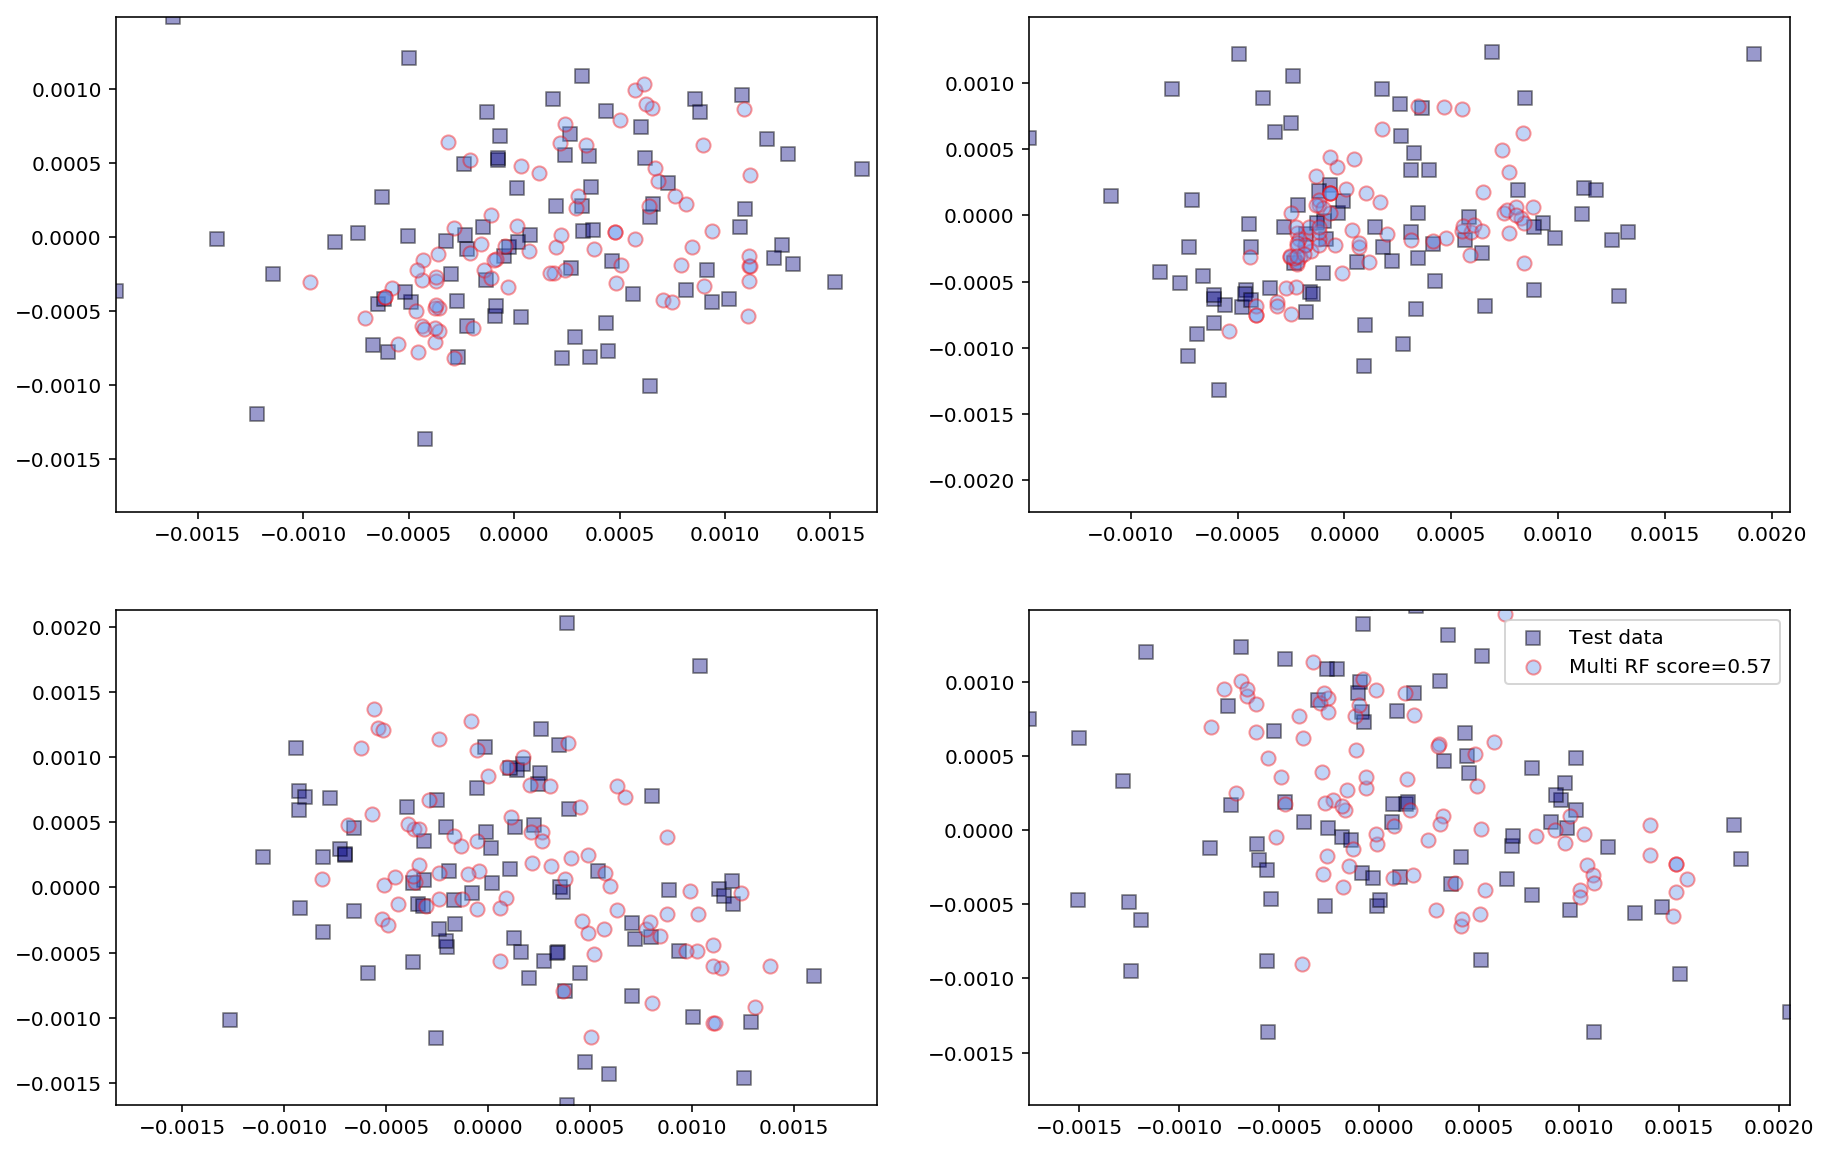

In [12]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(15)

s = 50
a = 0.4

[axs[i//2,i%2].scatter(Y_test[corrs[2*i]],Y_test[corrs[2*i+1]], 
                       edgecolor='k', c="navy", s=s, marker="s", alpha=a, label="Test data") for i in range(4)]


[axs[i//2,i%2].scatter(y_multirf[:, 2*i], y_multirf[:, 2*i+1], edgecolor='r',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, Y_test) ) for i in range(4)]


[axs[i//2,i%2].set_xlim([df[corrs[2*i]].min(), df[corrs[2*i]].max()]) for i in range(4)]
[axs[i//2,i%2].set_ylim([df[corrs[2*i+1]].min(), df[corrs[2*i+1]].max()]) for i in range(4)]


#plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='r',
#            c="cornflowerblue", s=s, alpha=a,
#            label="Multi RF score=%.2f" % regr_multirf.score(X_test, Y_test))

plt.xlim
plt.ylim([df["k03kh1"].min(), df["k03kh1"].max()])
plt.legend()
plt.show()

In [35]:
add_err()

# ! add smth unknown to the lattice
#madx.input('''ksf:=-0*7.63502808/6;ksd:=0*7.21301328/6;twiss;''')

DF0=madx.table.twiss.dframe()
dxdk0 =find_variation_x(np.zeros(8))

vec_predict = regr_multirf.predict([dxdk0])

err1 =madx.table.efield.dframe()
qsERR1 = err1[err1["name"].str.contains("q")]
qsPos1 = DF0[DF0["keyword"]=="quadrupole"]


In [36]:
vec_xg_dt = som(find_gradient_x, vec_predict[0], method="COBYLA", constraints=cons, options={'rhobeg': .0001, 'disp': True})

def con2(theta):
    return 0.01-np.linalg.norm(theta)*np.sqrt(8)
    
cons = [{"type": "ineq", "fun": con2}]
# switched on sextupoles require more strict limitations to correctors!


theta_x = np.zeros(8)
vec_xg = som(find_gradient_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .001, 'disp': True})
vec_xo = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .001, 'disp': True})

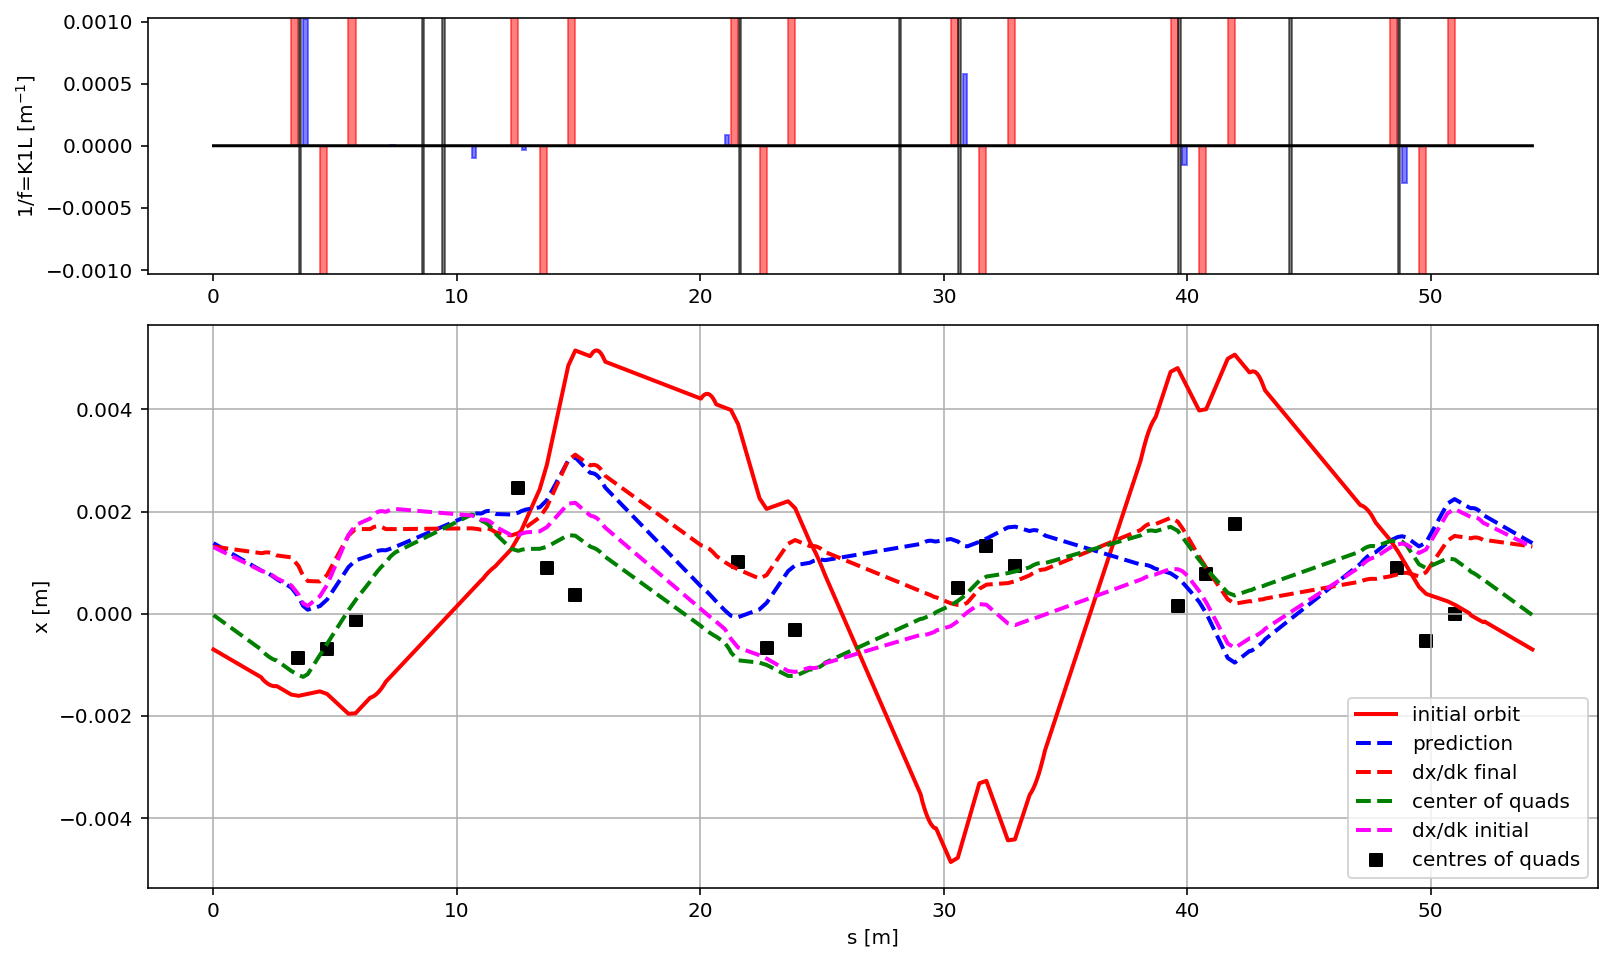

In [37]:
madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282;''')


madx.input('''k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
twiss;'''.format(*vec_predict[0]));

DF=madx.table.twiss.dframe()

madx.input('''k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
twiss;'''.format(*vec_xg_dt.x));

DF1=madx.table.twiss.dframe()
bpmDF1 = DF1[DF1["keyword"]=="hmonitor"]


madx.input('''k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
twiss;'''.format(*vec_xo.x));

DF2=madx.table.twiss.dframe()

madx.input('''k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
twiss;'''.format(*vec_xg.x));

DF3=madx.table.twiss.dframe()


# plotting
fig = plt.figure(figsize=(13,8))
ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(DF['s'],0*DF['s'],'k')

tmp=DF1[DF1['keyword']=='quadrupole']
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

hk = []
tmp=DF1[(DF1['keyword']=='hkicker')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.hkick, v_offset=aux.hkick/2, color='blue')
    hk.append(aux.hkick)
    color = 'red'

tmp=DF1[(DF1['keyword']=='hmonitor')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=0.005, color='black')
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=-0.005, color='black')
    color = 'black'

    
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
bnd = max(np.abs(hk))
plt.ylim(-bnd-10**(-5),bnd+10**(-5))

axbeta=plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)


plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)

plt.plot(DF['s'],DF['x'],'blue',ls="--", label='prediction', lw=2)
plt.plot(DF1['s'],DF1['x'],'red',ls="--", label='dx/dk final', lw=2)
plt.plot(DF2['s'],DF2['x'],'green',ls="--", label='center of quads', lw=2)
plt.plot(DF3['s'],DF3['x'],'magenta',ls="--", label='dx/dk initial', lw=2)

plt.scatter(qsPos1.s,qsERR1.dx, label="centres of quads", marker = "s", color = "black")

plt.legend(loc='best')
#plt.title("Horizontal orbit correction")
plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()


In [27]:
vectors = [np.zeros(8),vec_predict[0], vec_xg, vec_xg_dt, vec_xo]
names = ["zero","prediction", "dx/dk from zero", "dx/dk from prediction", "dx(q) from zero"]
df1 = pd.DataFrame(columns=["name","final dx/dk","final dx(q)", "opt. steps"])

for i,vec in enumerate(vectors):
    if i>1:
        g = find_gradient_x(vec.x)
        qo = find_orb_x(vec.x)
        n = vec.nfev
    else:
        g = find_gradient_x(vec)
        qo = find_orb_x(vec)
        n = 1
    df1 = df1.append({"name":names[i],"final dx/dk":g,"final dx(q)":qo, "opt. steps":n}, ignore_index=True)

In [28]:
df1

,name,final dx/dk,final dx(q),opt. steps
0,zero,0.411647,0.026064,1
1,prediction,0.051662,0.008393,1
2,dx/dk from zero,0.030067,0.008506,43
3,dx/dk from prediction,0.037881,0.007857,13
4,dx(q) from zero,0.033728,0.005670,46
